In [242]:
import pandas as pd

In [280]:
# Import pitstop data
# We want to join circuit name on raceId and team on driverId
ps_data = pd.read_csv("data/pit_stops.csv", index_col=False)

In [244]:
ps_data.head()

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


In [281]:
# Import race and circuit data
race_data = pd.read_csv("data/races.csv", index_col=False)
circ_data = pd.read_csv("data/circuits.csv", index_col=False)

In [282]:
# Joinin curcuit with race
circ_of_race = race_data.drop(columns=["name", "url"]).join(circ_data.set_index("circuitId"), on="circuitId")

circ_of_race = circ_of_race[["raceId", "year", "circuitId", "name"]]


In [283]:
circ_of_race.head()

,raceId,year,circuitId,name
0,1,2009,1,Albert Park Grand Prix Circuit
1,2,2009,2,Sepang International Circuit
2,3,2009,17,Shanghai International Circuit
3,4,2009,3,Bahrain International Circuit
4,5,2009,4,Circuit de Barcelona-Catalunya


In [284]:
# Now creating a df where we join pitstop data with circ and race data.
predDF = ps_data.join(circ_of_race.set_index("raceId"), on="raceId").drop(columns=["time", "stop", "duration"])

In [264]:
predDF.head()

,raceId,driverId,lap,milliseconds,year,circuitId,name
0,841,153,1,26898,2011,1,Albert Park Grand Prix Circuit
1,841,30,1,25021,2011,1,Albert Park Grand Prix Circuit
2,841,17,11,23426,2011,1,Albert Park Grand Prix Circuit
3,841,4,12,23251,2011,1,Albert Park Grand Prix Circuit
4,841,13,13,23842,2011,1,Albert Park Grand Prix Circuit


In [285]:
# Now we only need which team it is.
# We map driverId and raceId to contructorId from the results-data
res_data = pd.read_csv("data/results.csv", index_col=False)

In [251]:
res_data.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [286]:
# Keep relevant columns
const_data = res_data[["raceId", "driverId", "constructorId"]]

In [287]:
# Join based on raceId and driverId
predDF = predDF.join(const_data.set_index(["raceId", "driverId"]), on=["raceId", "driverId"])

In [254]:
predDF.head()

,raceId,driverId,lap,milliseconds,year,circuitId,name,constructorId
0,841,153,1,26898,2011,1,Albert Park Grand Prix Circuit,5
1,841,30,1,25021,2011,1,Albert Park Grand Prix Circuit,131
2,841,17,11,23426,2011,1,Albert Park Grand Prix Circuit,9
3,841,4,12,23251,2011,1,Albert Park Grand Prix Circuit,6
4,841,13,13,23842,2011,1,Albert Park Grand Prix Circuit,6


In [288]:
# For prediction, we don't need raceId, driverId or name.
predDF = predDF.drop(columns=["raceId", "driverId", "name"])

In [289]:
#final data for modelling
predDF.head()

,lap,milliseconds,year,circuitId,constructorId
0,1,26898,2011,1,5
1,1,25021,2011,1,131
2,11,23426,2011,1,9
3,12,23251,2011,1,6
4,13,23842,2011,1,6


In [314]:
# Only looking at 2015-2020 data
predDF = predDF[predDF.year.between(2015, 2020)]

# Outlier are sorted out above 30s
predDF = predDF[predDF.milliseconds.between(0, 30000)]

predDF.milliseconds.describe()

count     3586.000000
mean     23664.833519
std       2900.161880
min      14943.000000
25%      22174.250000
50%      23435.500000
75%      25033.750000
max      29998.000000
Name: milliseconds, dtype: float64

In [315]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

y = predDF["milliseconds"]
X = predDF.drop(columns="milliseconds")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [316]:
clf = XGBRegressor()
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=4, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [317]:
from sklearn.metrics import confusion_matrix
yp = clf.predict(X_test)

In [318]:
res = pd.DataFrame(y_test)
res["pred"] = yp
res = res.rename(columns={"milliseconds":"real"})

In [319]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

mse = mean_squared_error(yp, y_test)
mae = mean_absolute_error(yp, y_test)

print(f"RMSE: {math.sqrt(mse)} MAE: {mae}")

RMSE: 1537.1695451668836 MAE: 969.0573125217618


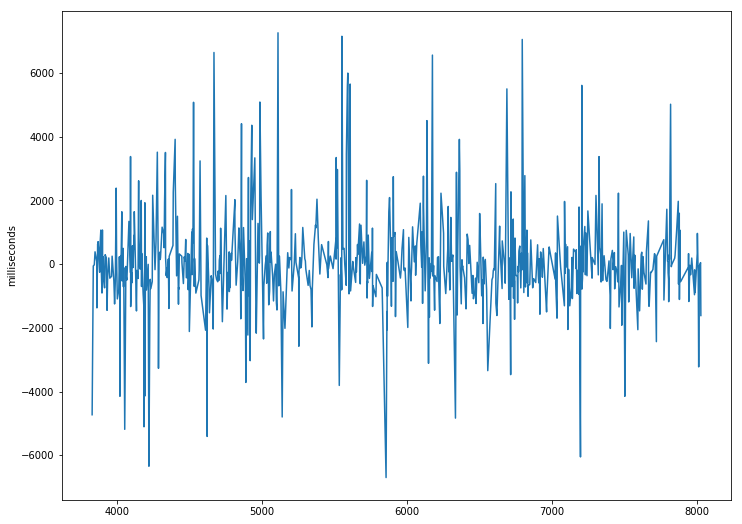

In [320]:
diff = abs(y_test-yp)
plt.figure(figsize=(12,9))
sns.lineplot(data=diff)

In [321]:
diff.describe()

count     718.000000
mean       13.415782
std      1538.182531
min     -6697.574219
25%      -623.294434
50%       -92.081055
75%       472.512695
max      7260.521484
Name: milliseconds, dtype: float64